### Unzipping Files

In [ ]:
! unzip BSR.zip

Archive:  BSR.zip
   creating: BSR/
   creating: BSR/BSDS500/
   creating: BSR/BSDS500/data/
   creating: BSR/BSDS500/data/groundTruth/
   creating: BSR/BSDS500/data/groundTruth/1/
  inflating: BSR/BSDS500/data/groundTruth/1/10081.mat  
  inflating: BSR/BSDS500/data/groundTruth/1/14085.mat  
  inflating: BSR/BSDS500/data/groundTruth/1/14092.mat  
  inflating: BSR/BSDS500/data/groundTruth/1/15011.mat  
  inflating: BSR/BSDS500/data/groundTruth/1/15062.mat  
  inflating: BSR/BSDS500/data/groundTruth/1/16004.mat  
  inflating: BSR/BSDS500/data/groundTruth/1/16068.mat  
  inflating: BSR/BSDS500/data/groundTruth/1/17067.mat  
  inflating: BSR/BSDS500/data/groundTruth/1/20069.mat  
  inflating: BSR/BSDS500/data/groundTruth/1/2018.mat  
  inflating: BSR/BSDS500/data/groundTruth/1/23050.mat  
  inflating: BSR/BSDS500/data/groundTruth/1/28083.mat  
  inflating: BSR/BSDS500/data/groundTruth/1/29030.mat  
  inflating: BSR/BSDS500/data/groundTruth/1/3063.mat  
  inflating: BSR/BSDS500/data/groundT

### Imports

In [ ]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.io
import os
import glob
import cv2
import matplotlib.image as mpimg
import scipy.io as sio
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from PIL import Image
from sklearn.metrics.cluster import contingency_matrix
import sklearn.metrics as metrics
from scipy.spatial import distance_matrix
from sklearn.neighbors import kneighbors_graph

## Part 1

### Reading Images

In [ ]:
OrginalImagesRoot = 'BSR/BSDS500/data/images/1/' 
GroundTruthRoot = 'BSR/BSDS500/data/groundTruth/1/'
Orginal_Test_Images=[]
Ground_Images=[]
Test_Images=[]
i=0
Totalfmeasures=np.zeros((50,5))
Totalentropy=np.zeros((50,5))

for img in glob.glob(f'{OrginalImagesRoot}/*.jpg'):
  
  Test_Img =cv2.imread(img)
  Test_Img=cv2.cvtColor(Test_Img, cv2.COLOR_BGR2RGB)
  Orginal_Test_Images.append(Test_Img)
  gname=os.path.splitext(os.path.basename(img))[0]
  i += 1
  Ground_Img = sio.loadmat(f'{GroundTruthRoot}{gname}')
  for i in range(0,5):
    Ground_Images.append(Ground_Img['groundTruth'][0][i][0][0][0])


 
Ground_Images=np.array(Ground_Images)
Orginal_Test_Images=np.array(Orginal_Test_Images)
for i in range(0,50):
  x=Orginal_Test_Images[i].reshape((-1,3))
  x=np.float32(x)
  Test_Images.append(x)
Test_Images=np.array(Test_Images)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


## Part 2

### Displaying Ground Truthes

In [ ]:

def Display_Img_GroundTruth(TestIMG, GroundIMG, index):
    f, axes = plt.subplots(1,6,figsize=(20,5))
    r,c=2,3
    axes[0].imshow(TestIMG[index],aspect='auto')
    axes[0].axis('off')
    idx = index * 5

    axes[1].imshow(GroundIMG[idx] , aspect='auto')
    axes[1].axis('off')
    axes[2].imshow(GroundIMG[idx+1],aspect='auto')
    axes[2].axis('off')
    axes[3].imshow(GroundIMG[idx+2],aspect='auto')
    axes[3].axis('off')
    axes[4].imshow(GroundIMG[idx+3],aspect='auto')
    axes[4].axis('off')
    axes[5].imshow(GroundIMG[idx+4],aspect='auto')
    axes[5].axis('off')
    plt.subplots_adjust(wspace=0.02,hspace=0.02)
    plt.show()

### Displaying Contours

In [ ]:
def Display_Img_GroundTruth_Contour(TestIMG, GroundIMG, index):


    OrginalImagesRoot = 'BSR/BSDS500/data/images/1/' 
    GroundTruthRoot = 'BSR/BSDS500/data/groundTruth/1/'
    img='BSR/BSDS500/data/images/1/2018.jpg' 

    Test_Img =cv2.imread(img)
    Test_Img=cv2.cvtColor(Test_Img, cv2.COLOR_BGR2RGB)
    gname=os.path.splitext(os.path.basename(img))[0]





    Ground_Img = sio.loadmat(f'{GroundTruthRoot}{gname}')
    gimg=[]
    for i in range(0,5):
      gimg.append(Ground_Img['groundTruth'][0][i][0][0][1])


    gimg=np.array(gimg)
    idx = index * 5
    j=0




    f, axes = plt.subplots(1,6,figsize=(20,5))
    r,c=2,3
    axes[0].imshow(Test_Img,aspect='auto')
    axes[0].axis('off')

    for i in range(1,6):
      axes[i].imshow(gimg[j] , aspect='auto',cmap='binary')
      axes[i].axis('off')
      j=j+1


## Part 3

Kmeans Functions

In [ ]:
def Segmentation(index):
  f, axes = plt.subplots(1,6,figsize=(20,5))
  j=0
  k=[3,5,7,9,11]
  seg=[]
  fmeasure=np.zeros((5,5))
  fmeasure2=np.zeros((5,5))
  entropy=np.zeros((5,5))
  for j in range(5):
    kmeans = KMeans(n_clusters=k[j])
    kmeans.fit(Test_Images[index]) 
    labels=kmeans.predict(Test_Images[index])
    for h in range(5):
     fmeasure[j][h] = f_measure(Ground_Images[index*5+h],labels,k[j])
     entropy[j][h] = Conditional_entropy(Ground_Images[index*5+h],labels,k[j])
    centers=kmeans.cluster_centers_
    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]
    segmented_image= segmented_data.reshape((Orginal_Test_Images[index].shape))
    segmented_image = np.array([j for j in kmeans.labels_]).reshape(Orginal_Test_Images[index].shape[0],Orginal_Test_Images[index].shape[1]) 
    seg.append(segmented_image)
  axes[0].imshow(Orginal_Test_Images[index],aspect='auto')
  axes[0].axis('off')
  idx=0
  for i in range(1,6):
    axes[i].imshow(seg[idx] , aspect='auto')
    axes[i].axis('off')
    idx=idx+1

  print('(Kmeans)Average fmeasure for each K')
  print(np.mean(fmeasure,axis=1))
  Totalfmeasures[index]=np.mean(fmeasure,axis=1)
  print('(Kmeans)Average entropy for each K')
  print(np.mean(entropy,axis=1))
  Totalentropy[index]=np.mean(entropy,axis=1)
  plt.subplots_adjust(wspace=0.02,hspace=0.02)

F-measure

In [ ]:
def f_measure(y_true, y_pred,k):
  contingency__matrix = contingency_matrix(y_true, y_pred).T
  perc=[]
  recall=[]
  fmeasure=0
  for i in range(contingency__matrix.shape[0]):
    perc.append(max(contingency__matrix[i])/np.sum(contingency__matrix[i]))
 

    maxindex=np.argmax(contingency__matrix[i])
    recall.append(max(contingency__matrix[i])/np.sum(contingency__matrix[:,maxindex]))
    fmeasure=fmeasure+(2*perc[i]*recall[i])/(perc[i]+recall[i])
  return fmeasure/k




Conditional Entropy

In [ ]:
def Conditional_entropy(y_true, y_pred,k):
  contingency__matrix = metrics.cluster.contingency_matrix(y_true, y_pred).T
  
  j=0
  x=0
  HSC=[]
  for i in range(contingency__matrix.shape[0]):
      for j in range(contingency__matrix.shape[1]):
        denim=0
        if contingency__matrix[i][j]/np.sum(contingency__matrix[i])!=0:
          denim=np.log10(contingency__matrix[i][j]/np.sum(contingency__matrix[i]))
        x =x+(-contingency__matrix[i][j]/np.sum(contingency__matrix[i]))*denim

      HSC.append(x)
      x=0



  HSC=np.array(HSC)
  HSC_result=0
  for i in range(contingency__matrix.shape[0]):
    x=np.sum(contingency__matrix[i])/np.sum(contingency__matrix)
    HSC_result=HSC_result+x*HSC[i]

  return HSC_result

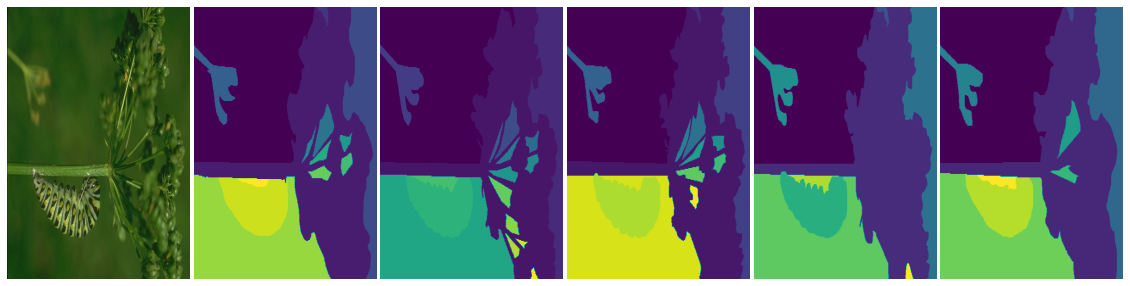

In [ ]:
Display_Img_GroundTruth(Orginal_Test_Images,Ground_Images, 48)

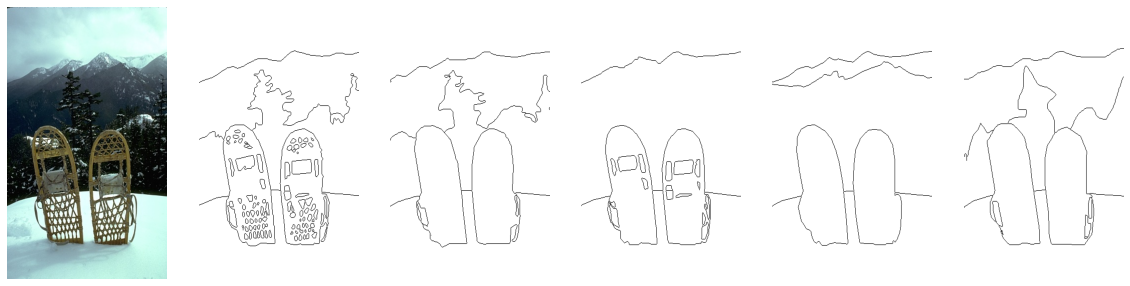

In [ ]:
Display_Img_GroundTruth_Contour(Orginal_Test_Images,Ground_Images, 4)

(Kmeans)Average fmeasure for each K
[0.6226159  0.46555316 0.37740751 0.31592203 0.27214167]
(Kmeans)Average entropy for each K
[0.39780971 0.37770141 0.37246545 0.36747783 0.36284029]


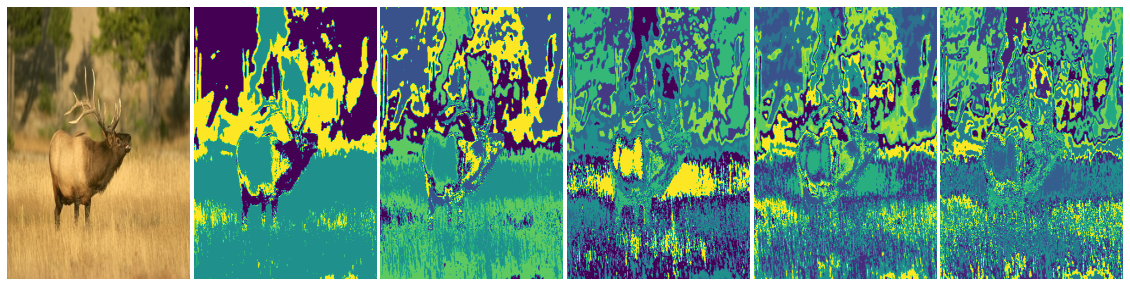

In [ ]:
Segmentation(6)

## Part 4

In [ ]:
def Segmentation_Aganist_GroundTruth(index,i):
  from sklearn.cluster import KMeans
  j=0
  k=[3,5,7,9,11]
  seg=[]
  for j in range(5): 
   print("segmentation results using K-means at k=",k[i]) 
   SegmentationK5(index+j,1)
   Display_Img_GroundTruth(Orginal_Test_Images,Ground_Images, index+j)

In [ ]:
def SegmentationK5(index,i):
 j=0
 k=[3,5,7,9,11]
 seg=[]
 fmeasure=np.zeros((1,5))
 entropy=np.zeros((1,5))
 kmeans = KMeans(n_clusters=k[i])
 kmeans.fit(Test_Images[index+j]) 
 labels=kmeans.predict(Test_Images[index])
 for i in range(0,5):
  fmeasure[0][i] = f_measure(Ground_Images[index*5+i],labels,5)
  entropy[0][i] = Conditional_entropy(Ground_Images[index*5+i],labels,5)

 centers=kmeans.cluster_centers_
 centers = np.uint8(centers)
 segmented_data = centers[labels.flatten()]
 segmented_image= segmented_data.reshape((Orginal_Test_Images[index].shape))
 segmented_image = np.array([j for j in kmeans.labels_]).reshape(Orginal_Test_Images[index].shape[0],Orginal_Test_Images[index].shape[1])
 seg.append(segmented_image)
 plt.imshow(segmented_image,aspect='auto')
 print('Average F-measure')
 print(np.mean(fmeasure))
 print('Average Entropy')
 print(np.mean(entropy))

### 4A

segmentation results using K-means at k= 5
Average F-measure
0.42156502941020674
Average Entropy
0.3847935093412197


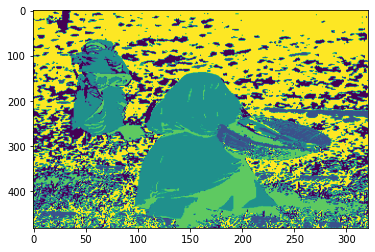

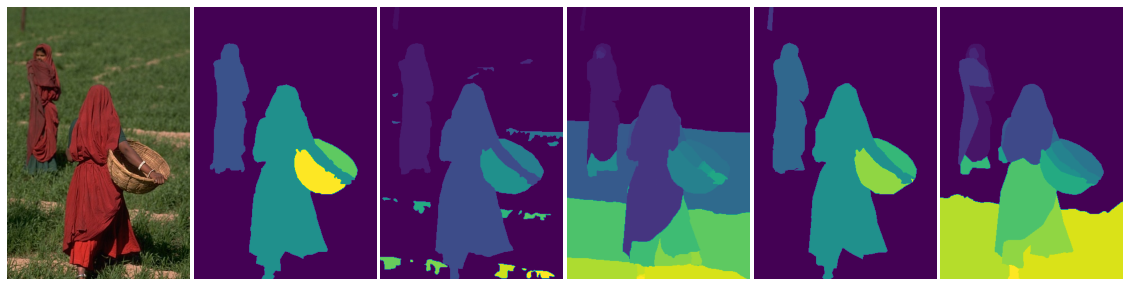

segmentation results using K-means at k= 5
Average F-measure
0.37918148173512434
Average Entropy
0.6131378183805177


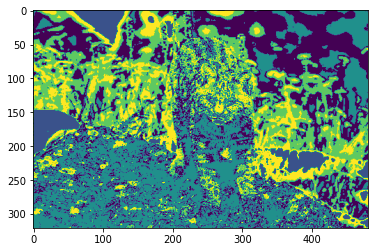

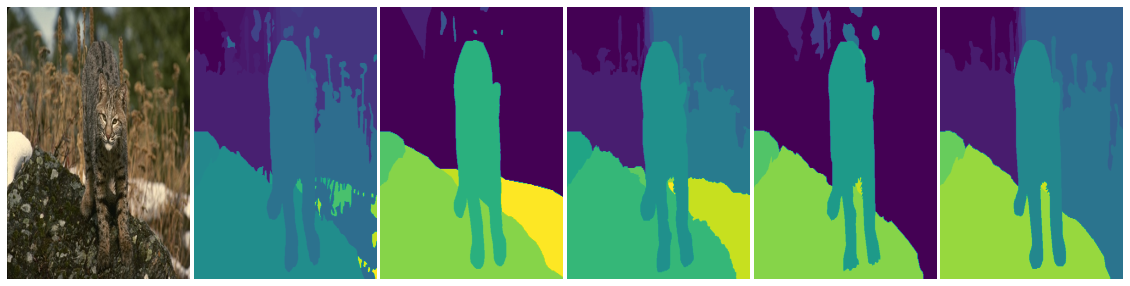

segmentation results using K-means at k= 5
Average F-measure
0.4397773557818356
Average Entropy
0.6875676729498063


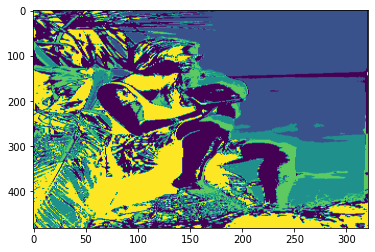

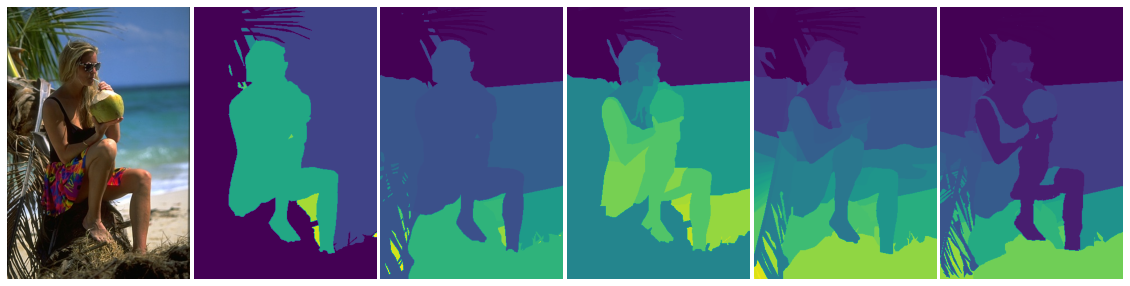

segmentation results using K-means at k= 5
Average F-measure
0.47364046425917783
Average Entropy
0.3182884030011427


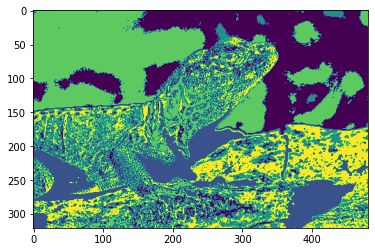

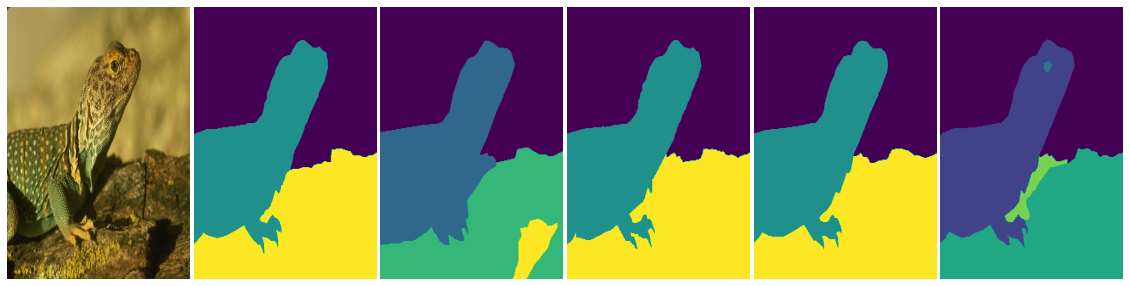

segmentation results using K-means at k= 5
Average F-measure
0.28373371255753843
Average Entropy
0.7899292195244917


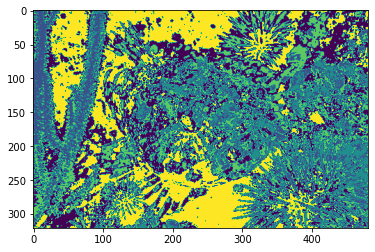

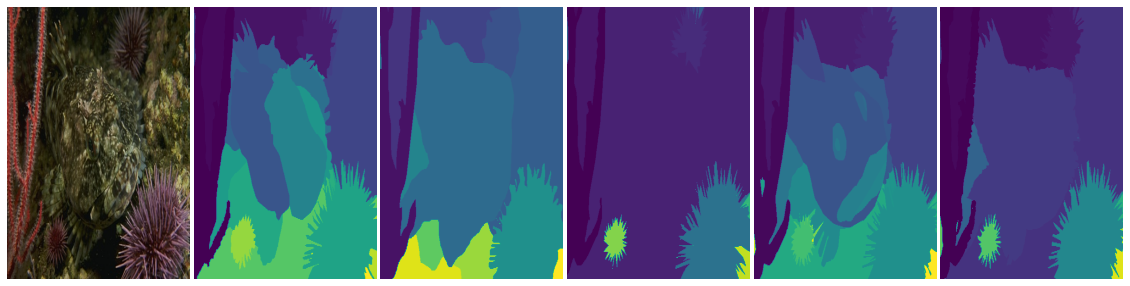

In [ ]:
Segmentation_Aganist_GroundTruth(9,1)

In [ ]:
def spectral_clustering(index, scale_percent):
  # Reshaped Height and Width
  width = int(Orginal_Test_Images[index].shape[0] * scale_percent / 100)
  height = int(Orginal_Test_Images[index].shape[1] * scale_percent / 100)
  dim = (width, height)
  img=Orginal_Test_Images[index]  
  resized = cv2.resize(img, dim)
  resizedTestImg = (resized).reshape(-1 ,3)

  
  cluster = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', n_neighbors=5).fit_predict(resizedTestImg)
  fmeasure=np.zeros((1,5))
  entropy=np.zeros((1,5))
  segmented_results = np.array([j for j in cluster]).reshape(height,width)
  dim2=(segmented_results.shape[0],segmented_results.shape[1])
  for h in range(5):
     x = cv2.resize(Ground_Images[index*5+h], dim2)
     fmeasure[0][h] = f_measure(x,segmented_results,5)
     entropy[0][h] = Conditional_entropy(x,segmented_results,5)
  print('(Spectral Clustering) Average fmeasure for each K')
  print(np.mean(fmeasure,axis=1))
  print('(Spectral Clustering) Average entropy for each K')
  print(np.mean(entropy,axis=1))   
  plt.imshow(segmented_results,aspect='auto')
  
  plt.show()

 

### 4B

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


(Spectral Clustering) Average fmeasure for each K
[0.28988526]
(Spectral Clustering) Average entropy for each K
[0.31514832]


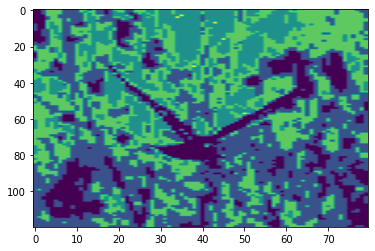

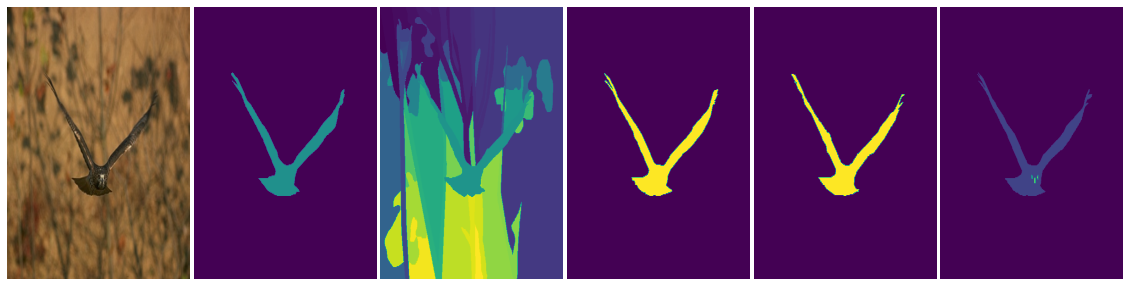

In [ ]:
spectral_clustering(5,25)
Display_Img_GroundTruth(Orginal_Test_Images,Ground_Images, 5)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


(Spectral Clustering) Average fmeasure for each K
[0.28]
(Spectral Clustering) Average entropy for each K
[0.34745219]


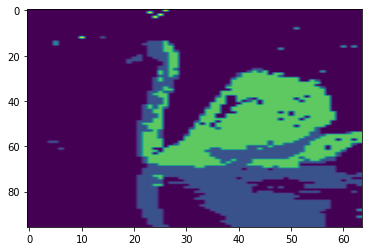

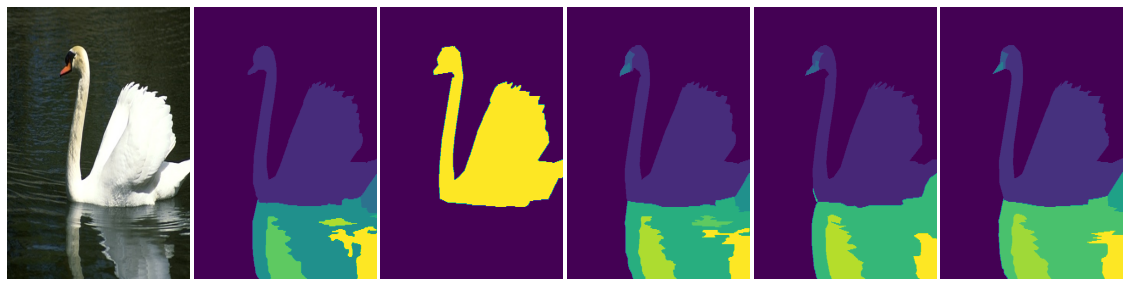

In [ ]:
spectral_clustering(40,20)
Display_Img_GroundTruth(Orginal_Test_Images,Ground_Images, 40)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


(Spectral Clustering) Average fmeasure for each K
[0.31996952]
(Spectral Clustering) Average entropy for each K
[0.40680675]


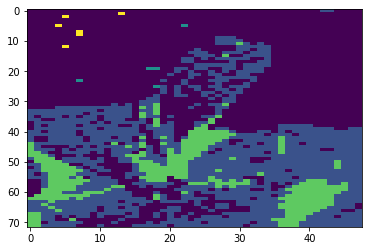

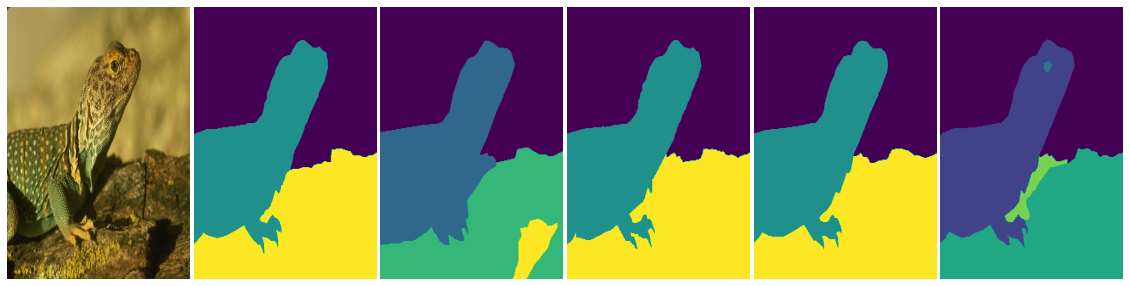

In [ ]:
spectral_clustering(12,15)
Display_Img_GroundTruth(Orginal_Test_Images,Ground_Images, 12)

(Spectral Clustering) Average fmeasure for each K
[0.28547931]
(Spectral Clustering) Average entropy for each K
[0.52415097]


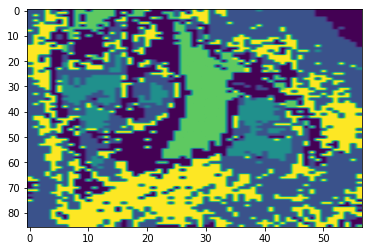

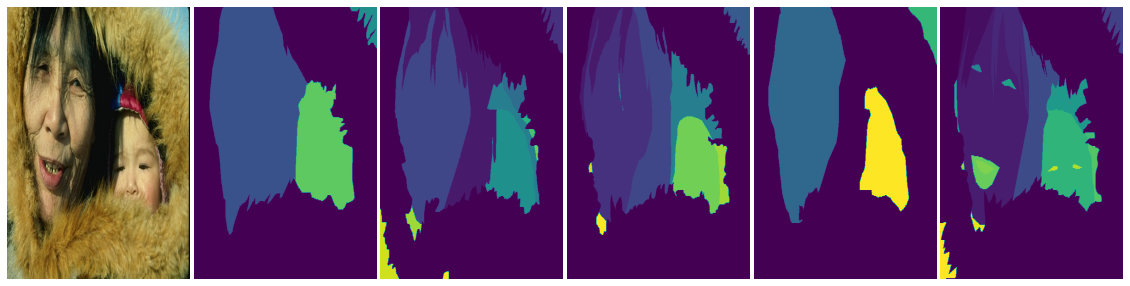

In [ ]:
spectral_clustering(24,18)
Display_Img_GroundTruth(Orginal_Test_Images,Ground_Images, 24)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


(Spectral Clustering) Average fmeasure for each K
[0.31107071]
(Spectral Clustering) Average entropy for each K
[0.57393222]


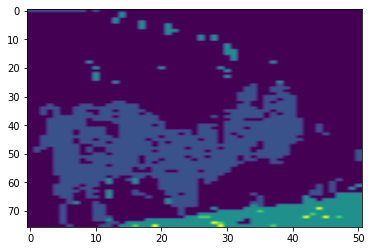

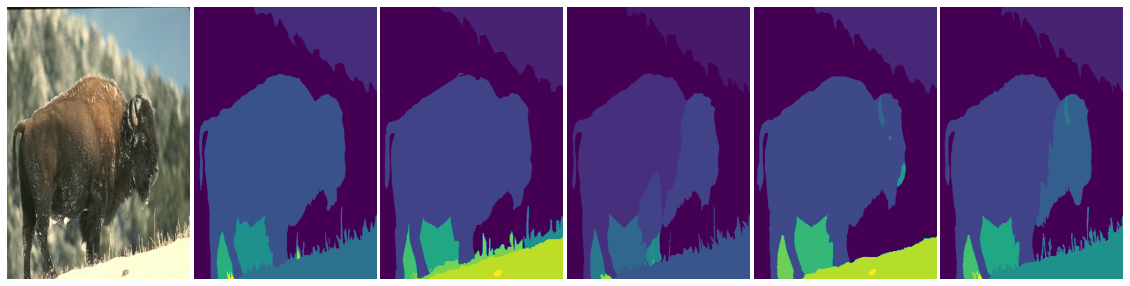

In [ ]:
spectral_clustering(43,16)
Display_Img_GroundTruth(Orginal_Test_Images,Ground_Images, 43)

### 4C

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


(Spectral Clustering) Average fmeasure for each K
[0.42]
(Spectral Clustering) Average entropy for each K
[0.43227585]


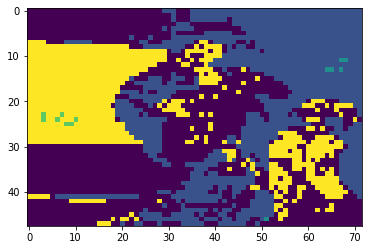

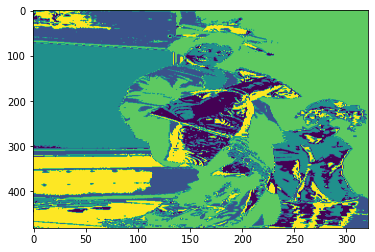

In [ ]:
spectral_clustering(18,15)
SegmentationK5(18,1)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


(Spectral Clustering) Average fmeasure for each K
[0.42]
(Spectral Clustering) Average entropy for each K
[0.32541807]


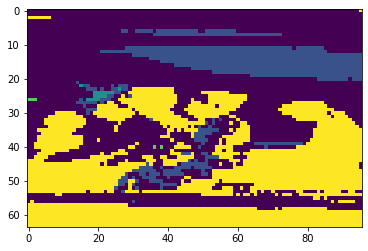

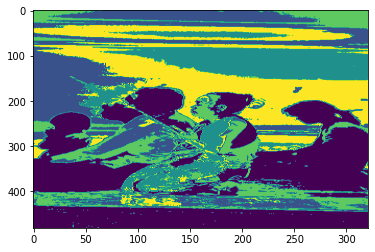

In [ ]:
spectral_clustering(34,20)
SegmentationK5(34,1)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


(Spectral Clustering) Average fmeasure for each K
[0.56]
(Spectral Clustering) Average entropy for each K
[0.31107478]


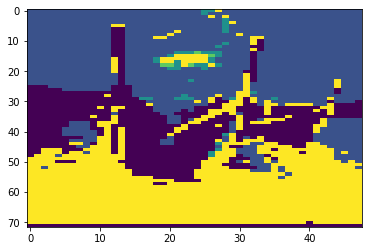

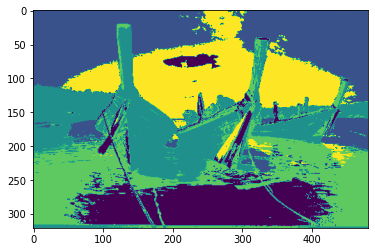

In [ ]:
spectral_clustering(19,15)
SegmentationK5(19,1)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


(Spectral Clustering) Average fmeasure for each K
[0.3]
(Spectral Clustering) Average entropy for each K
[0.41817106]


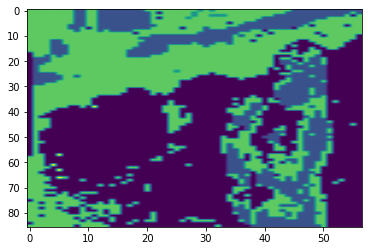

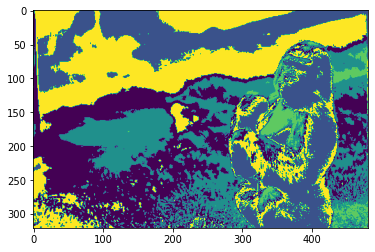

In [ ]:
spectral_clustering(26,18)
SegmentationK5(26,1)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


(Spectral Clustering) Average fmeasure for each K
[0.32]
(Spectral Clustering) Average entropy for each K
[0.55208321]


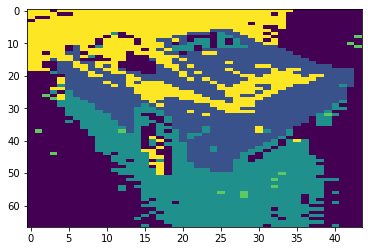

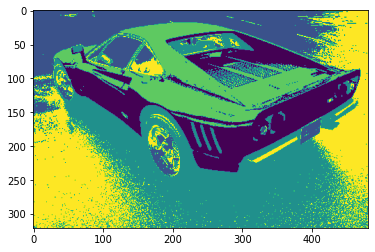

In [ ]:
spectral_clustering(31,14)
SegmentationK5(31,1)


##Part 5 (Extras)

In [ ]:
def spatialDistance(orgimage,index):
 f, axes = plt.subplots(1,6,figsize=(20,5))
 j=0
 k=[3,5,7,9,11]
 seg=[]
 fmeasure=np.zeros((5,5))
 entropy=np.zeros((5,5))
 for i in range(5):
  kmeans = KMeans(n_clusters=k[i])
  kmeans.fit(orgimage) 
  labels=kmeans.predict(orgimage)
  for h in range(5):
     fmeasure[i][h] = f_measure(Ground_Images[index*5+h],labels,k[i])
     entropy[i][h] = Conditional_entropy(Ground_Images[index*5+h],labels,k[i])
  centers=kmeans.cluster_centers_
  centers = np.uint8(centers)
  segmented_data = centers[labels.flatten()]
  segmented_image= segmented_data.reshape((orgimage.shape))
  segmented_image = np.array([j for j in kmeans.labels_]).reshape(Orginal_Test_Images[index].shape[0],Orginal_Test_Images[index].shape[1])
  seg.append(segmented_image)
 seg=np.array(seg) 
 print('(Spatial Layout)Average Fmeasure for each K(Spatial Layout)')
 print(np.mean(fmeasure,axis=1))
 print('(Spatial Layout)Average entropy for each K')
 print(np.mean(entropy,axis=1))
 axes[0].imshow(Orginal_Test_Images[index], aspect='auto')
 axes[0].axis('off')
 j=0
 for i in range(1,6):
    axes[i].imshow(seg[j], aspect='auto')
    axes[i].axis('off')
    j=j+1
    
plt.subplots_adjust(wspace=0.005,hspace=0.005)


<Figure size 432x288 with 0 Axes>

In [ ]:
def choosing_sp(index):
  img3d = np.copy(Orginal_Test_Images[index])
  img2d = img3d[:,:,0]     #   convert to 2D array
  row, col = img2d.shape
  x=[]
  y=[]
  for i in range(row):
      for j in range(col):
            x.append(i) #       get x indices
            y.append(j) #       get y indices
  x= np.array(x).reshape(img3d.shape[0]*img3d.shape[1],1)
  y=np.array(y).reshape(img3d.shape[0]*img3d.shape[1],1)
  img3d2 = img3d.reshape(img3d.shape[0]*img3d.shape[1],3)
  finalimg = np.append(img3d2,x,axis = 1)
  finalimg = np.append(finalimg,y,axis = 1)
  finalimg = finalimg.reshape(img3d.shape[0], img3d.shape[1],5)
  x=finalimg.reshape((-1,5))
  x=np.float32(x)
  spatialDistance(x,index)

(Spatial Layout)Average Fmeasure for each K(Spatial Layout)
[0.51471093 0.49297073 0.43431142 0.39365381 0.34399248]
(Spatial Layout)Average entropy for each K
[0.4863048  0.36831344 0.30445327 0.26434225 0.26181204]
(Kmeans)Average fmeasure for each K
[0.65280666 0.52427345 0.43252261 0.431034   0.39914053]
(Kmeans)Average entropy for each K
[0.40161385 0.34338245 0.33783986 0.32001832 0.28329277]


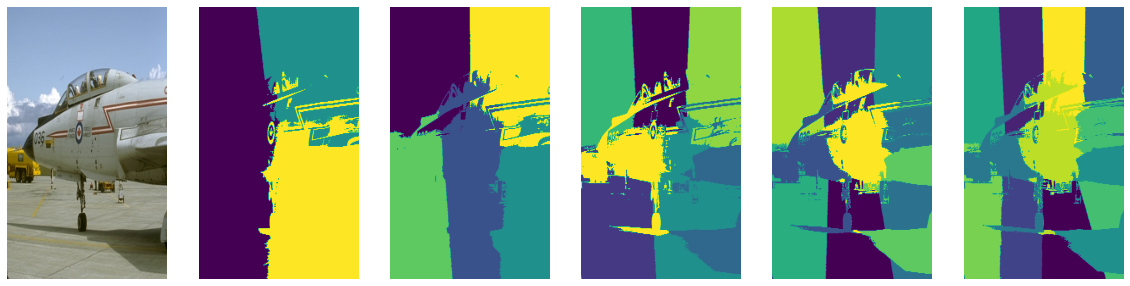

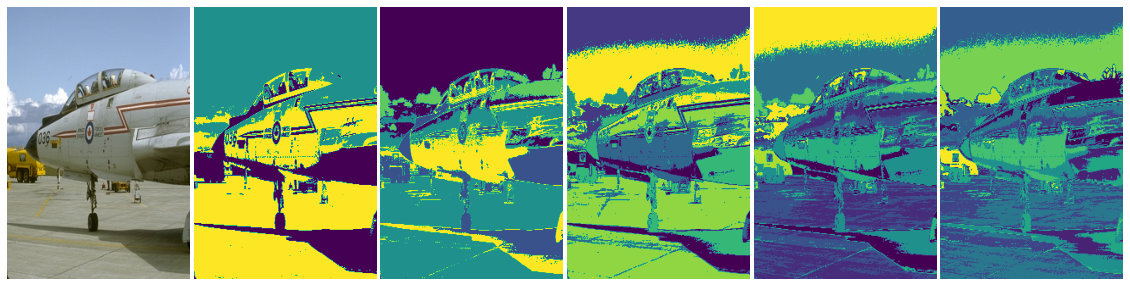

In [ ]:
choosing_sp(20)
Segmentation(20)

(Spatial Layout)Average Fmeasure for each K(Spatial Layout)
[0.64051518 0.51277397 0.45086072 0.46156842 0.40287551]
(Spatial Layout)Average entropy for each K
[0.41343435 0.33967607 0.33430899 0.28199832 0.27361633]
(Kmeans)Average fmeasure for each K
[0.44845502 0.50194549 0.41241417 0.34935016 0.30300896]
(Kmeans)Average entropy for each K
[0.58017311 0.52890717 0.51410615 0.50351381 0.49425651]


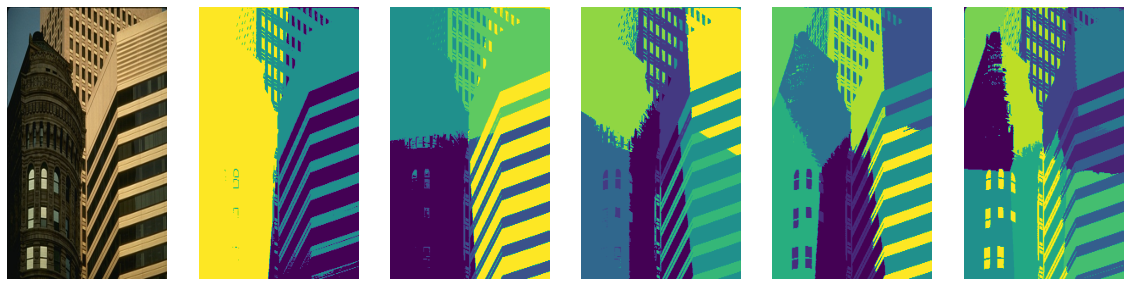

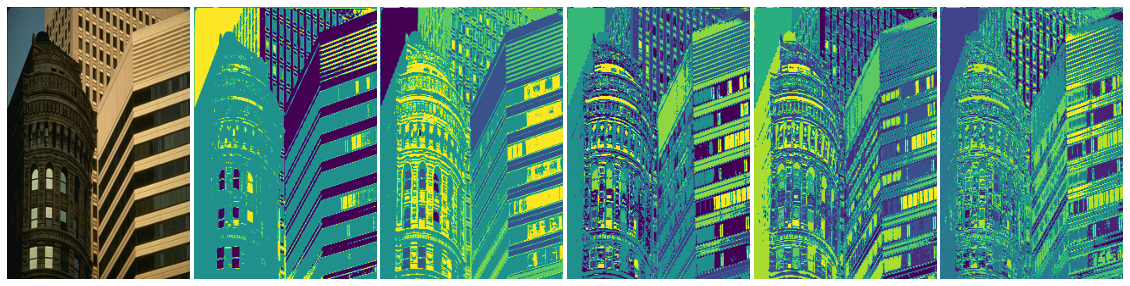

In [ ]:
choosing_sp(4)
Segmentation(4)

(Spatial Layout)Average Fmeasure for each K(Spatial Layout)
[0.63594903 0.52195711 0.47358327 0.43334854 0.41658595]
(Spatial Layout)Average entropy for each K
[0.43276992 0.33748832 0.25074453 0.20869734 0.1963427 ]
(Kmeans)Average fmeasure for each K
[0.71928915 0.64036596 0.52292484 0.47818625 0.46091507]
(Kmeans)Average entropy for each K
[0.29125594 0.25500517 0.24984588 0.23280747 0.19752518]


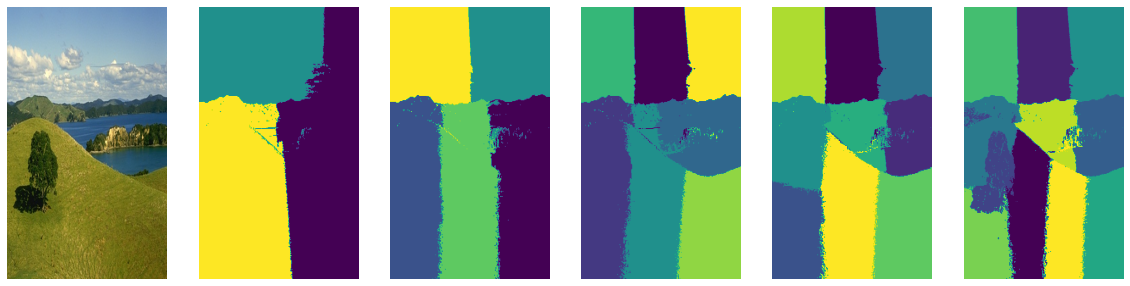

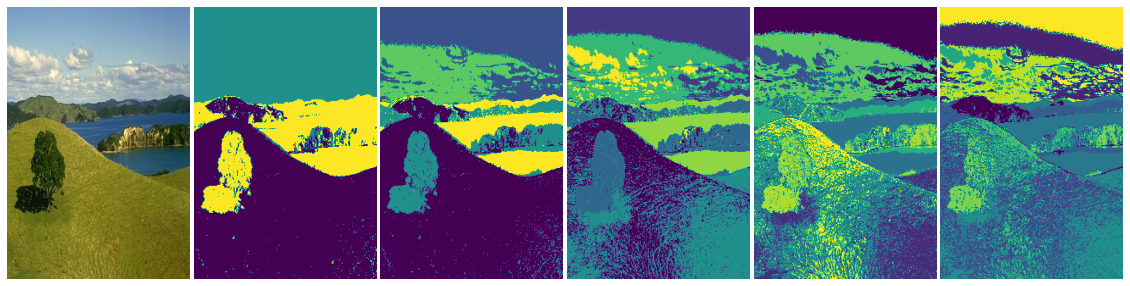

In [ ]:
choosing_sp(22)
Segmentation(22)

(Spatial Layout)Average Fmeasure for each K(Spatial Layout)
[0.64561761 0.60217331 0.51856369 0.45238814 0.39187574]
(Spatial Layout)Average entropy for each K
[0.46518923 0.33673488 0.28273529 0.27810756 0.25281215]
(Kmeans)Average fmeasure for each K
[0.7722885  0.68831188 0.5369868  0.45609594 0.38316468]
(Kmeans)Average entropy for each K
[0.4075446  0.3555404  0.30020401 0.2942693  0.28547603]


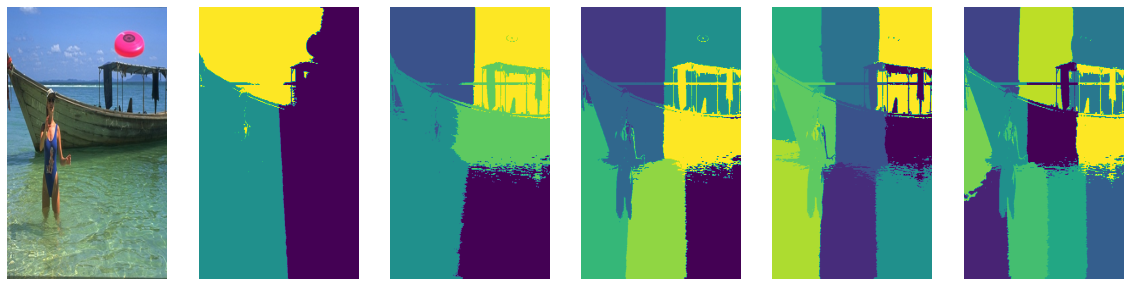

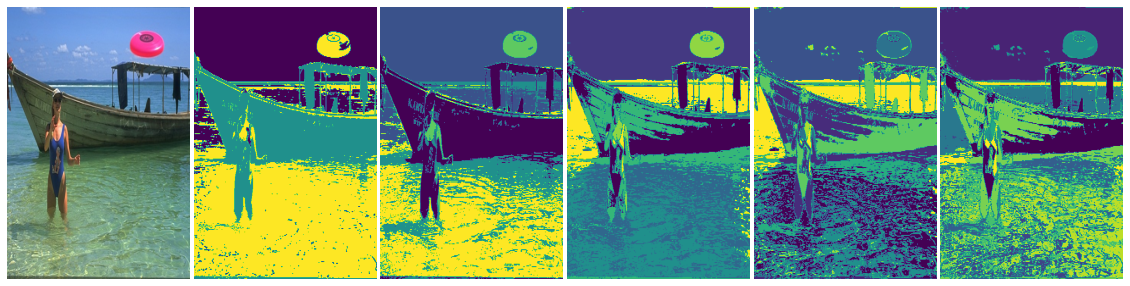

In [ ]:
choosing_sp(41)
Segmentation(41)

(Spatial Layout)Average Fmeasure for each K(Spatial Layout)
[0.67596975 0.56155352 0.46544887 0.47318298 0.40479096]
(Spatial Layout)Average entropy for each K
[0.51188356 0.44359179 0.39598644 0.35394975 0.33567721]
(Kmeans)Average fmeasure for each K
[0.63226343 0.49028272 0.39280664 0.39144557 0.36228032]
(Kmeans)Average entropy for each K
[0.57828051 0.54641926 0.54131689 0.49044167 0.45440924]


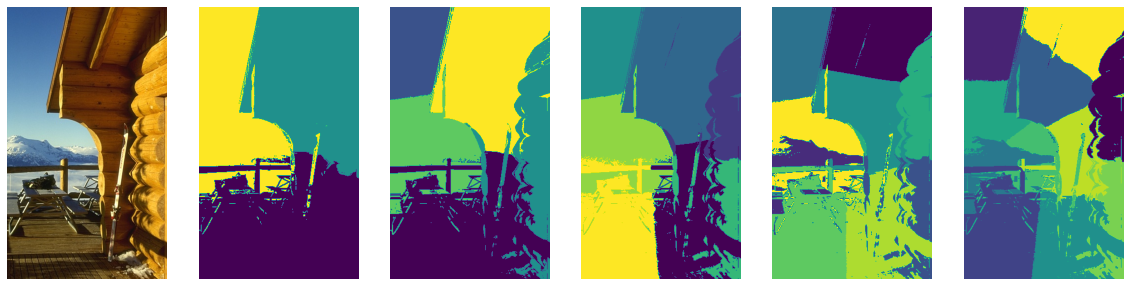

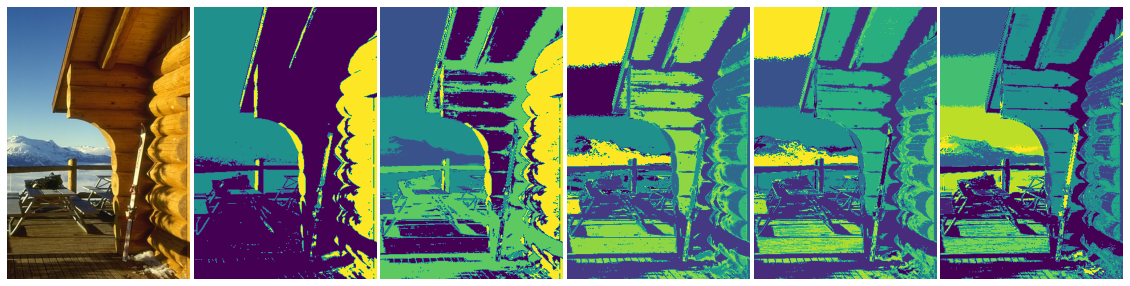

In [ ]:
choosing_sp(35)
Segmentation(35)

In [ ]:
for i in range(0,50):
  Segmentation(i)

In [ ]:
print(Totalfmeasures)

[[0.39781166 0.42633759 0.35330431 0.3367015  0.31636222]
 [0.43759623 0.29943833 0.23494091 0.18988329 0.1731321 ]
 [0.44734648 0.37739098 0.29719493 0.32521699 0.28842648]
 [0.37882184 0.41460754 0.37053704 0.35722448 0.37683654]
 [0.44831779 0.50203373 0.41243752 0.34914031 0.30093847]
 [0.44807111 0.3201621  0.3049202  0.24587236 0.20427926]
 [0.62274945 0.46885103 0.37389075 0.31723285 0.27236743]
 [0.56534618 0.45060722 0.38853618 0.34699723 0.31601115]
 [0.58095923 0.45328683 0.41444986 0.35009246 0.31611274]
 [0.56566322 0.42368017 0.40107182 0.3447441  0.31529395]
 [0.42200223 0.37515119 0.40690045 0.35674263 0.3172831 ]
 [0.51476627 0.43600357 0.44184636 0.39088938 0.35555233]
 [0.61316831 0.47352656 0.37814932 0.30957377 0.2728211 ]
 [0.32398549 0.2834918  0.26789692 0.23194519 0.21381751]
 [0.54184479 0.4293101  0.34688126 0.29790346 0.25287055]
 [0.5222616  0.43940822 0.41065198 0.37398902 0.34001192]
 [0.40703378 0.4466599  0.39257355 0.37594833 0.34368167]
 [0.53396028 0

In [ ]:
print(Totalentropy)

[[0.77553708 0.68475882 0.66728127 0.64580022 0.61880103]
 [0.31842193 0.31378551 0.31174516 0.31154676 0.30182677]
 [0.32528068 0.29888312 0.28927608 0.27376666 0.27136657]
 [1.00373098 0.95797512 0.91765999 0.87857479 0.85013629]
 [0.58032002 0.5289275  0.51411388 0.50395315 0.4953581 ]
 [0.28390471 0.2731391  0.26792469 0.26537992 0.26472217]
 [0.39771453 0.37822214 0.37203928 0.36631813 0.36318163]
 [0.61373949 0.52472855 0.4977638  0.46921282 0.44384654]
 [0.61561198 0.59831408 0.57810546 0.57248292 0.56463988]
 [0.44571418 0.38564301 0.34454089 0.34040815 0.32696753]
 [0.63969045 0.61365323 0.5972807  0.59129837 0.56753992]
 [0.77153013 0.68850646 0.64922906 0.62877022 0.61573531]
 [0.32940668 0.31878657 0.3029425  0.29784296 0.29442441]
 [0.80716865 0.78994352 0.76453363 0.76130418 0.75025164]
 [0.5214671  0.50388204 0.49565732 0.48922507 0.48601501]
 [0.55395749 0.54425417 0.52796351 0.49940506 0.48636644]
 [0.91888944 0.80187871 0.77774423 0.72682535 0.71811239]
 [0.3911246  0